# Fine Tuning Transformer for MultiLabel Text Classification

### Introduction

Ie **Multilabel text classification**: given piece of text/sentence/document needs to be classified into one or more of categories out of the given list. For example a movie can be categorized into 1 or more genres.

#### Flow of the notebook

The notebook will be divided into seperate sections to provide a organized walk through for the process used. This process can be modified for individual use cases. The sections are:

1. [Importing Python Libraries and preparing the environment](#section01)
2. [Importing and Pre-Processing the domain data](#section02)
3. [Preparing the Dataset and Dataloader](#section03)
4. [Creating the Neural Network for Fine Tuning](#section04)
5. [Fine Tuning the Model](#section05)
6. [Validating the Model Performance](#section06)
7. [Saving the model and artifacts for Inference in Future](#section07)


---
***NOTE***
- *It is to be noted that the overall mechanisms for a multiclass and multilabel problems are similar, except for few differences namely:*
	- *Loss function is designed to evaluate all the probability of categories individually rather than as compared to other categories. Hence the use of `BCE` rather than `Cross Entropy` when defining loss.*
	- *Sigmoid of the outputs calcuated to rather than Softmax. Again for the reasons defined in the previous point*
	- *The [accuracy metrics](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) and [F1 scores](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score) used from sklearn package as compared to direct comparison of expected vs predicted*
---

<a id='section01'></a>
### Importing Python Libraries and preparing the environment

At this step we will be importing the libraries and modules needed to run our script. Libraries are:
* Pandas
* Pytorch
* Pytorch Utils for Dataset and Dataloader
* Transformers
* BERT Model and Tokenizer

Followed by that we will preapre the device for GPU execeution.

In [25]:
# Loading the required libaries
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig
from torch import cuda

from IPython.display import display, HTML
from tqdm import tqdm
import matplotlib.pyplot as plt


# Setting up the device for GPU usage
device = torch.device("cuda:1" if cuda.is_available() else "cpu")
device

device(type='cuda', index=1)

<a id='section02'></a>
### Importing and Pre-Processing the domain data

We will be working with the data and preparing for fine tuning purposes.
*Assuming that the `mtsamples.csv` is already downloaded, unzipped and saved in your `data` folder*

In [26]:
df = pd.read_csv("./data/mtsamples.csv")
df.head()

,Unnamed: 0,description,medical_specialty,sample_name,transcription,keywords
0,0,A 23-year-old white female presents with comp...,Allergy / Immunology,Allergic Rhinitis,"SUBJECTIVE:, This 23-year-old white female pr...","allergy / immunology, allergic rhinitis, aller..."
1,1,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 2,"PAST MEDICAL HISTORY:, He has difficulty climb...","bariatrics, laparoscopic gastric bypass, weigh..."
2,2,Consult for laparoscopic gastric bypass.,Bariatrics,Laparoscopic Gastric Bypass Consult - 1,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ...","bariatrics, laparoscopic gastric bypass, heart..."
3,3,2-D M-Mode. Doppler.,Cardiovascular / Pulmonary,2-D Echocardiogram - 1,"2-D M-MODE: , ,1. Left atrial enlargement wit...","cardiovascular / pulmonary, 2-d m-mode, dopple..."
4,4,2-D Echocardiogram,Cardiovascular / Pulmonary,2-D Echocardiogram - 2,1. The left ventricular cavity size and wall ...,"cardiovascular / pulmonary, 2-d, doppler, echo..."


In [27]:
## We need to predict the medical specialty only from the transcription.

new_df = df[['medical_specialty', 'transcription']].copy()
new_df.head()

,medical_specialty,transcription
0,Allergy / Immunology,"SUBJECTIVE:, This 23-year-old white female pr..."
1,Bariatrics,"PAST MEDICAL HISTORY:, He has difficulty climb..."
2,Bariatrics,"HISTORY OF PRESENT ILLNESS: , I have seen ABC ..."
3,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
4,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...


In [28]:
# No of classes present in the dataset
no_of_labels = new_df['medical_specialty'].nunique()
print("No of unique labels: ", no_of_labels, "\n")

# Distribution of samples across classes
counts = {}
for spec in df['medical_specialty']:
    if spec not in counts:
        counts[spec] = 1
    else:
        counts[spec] += 1
dist = list(counts.values())
dist.sort(reverse=True)
print("Distribution of samples across lables: \n", dist, "\n")

print("Labels :", df['medical_specialty'].unique())


# Creating One hot encoded indices for the classes
mapping = {}
for i, spec in enumerate(counts):
    mapping[spec] = i

No of unique labels:  40 

Distribution of samples across lables: 
 [1103, 516, 372, 355, 273, 259, 230, 223, 166, 160, 158, 108, 98, 94, 90, 83, 81, 75, 70, 62, 53, 51, 47, 29, 27, 27, 23, 21, 20, 19, 18, 16, 14, 10, 10, 9, 8, 8, 7, 6] 

Labels : [' Allergy / Immunology' ' Bariatrics' ' Cardiovascular / Pulmonary'
 ' Neurology' ' Dentistry' ' Urology' ' General Medicine' ' Surgery'
 ' Speech - Language' ' SOAP / Chart / Progress Notes' ' Sleep Medicine'
 ' Rheumatology' ' Radiology' ' Psychiatry / Psychology' ' Podiatry'
 ' Physical Medicine - Rehab' ' Pediatrics - Neonatal' ' Pain Management'
 ' Orthopedic' ' Ophthalmology' ' Office Notes' ' Obstetrics / Gynecology'
 ' Neurosurgery' ' Nephrology' ' Letters' ' Lab Medicine - Pathology'
 ' IME-QME-Work Comp etc.' ' Hospice - Palliative Care'
 ' Hematology - Oncology' ' Gastroenterology' ' ENT - Otolaryngology'
 ' Endocrinology' ' Emergency Room Reports' ' Discharge Summary'
 ' Diets and Nutritions' ' Dermatology' ' Cosmetic / Plastic S

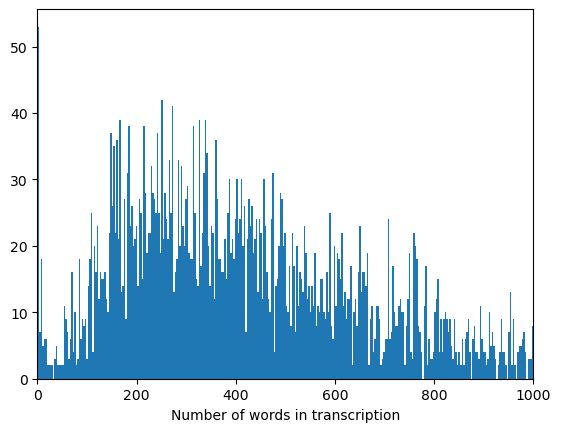

No of words in transcription greater than 512:  1731


In [29]:
lenght = []
for spec in df['transcription']:
    lenght.append(len(str(spec).split()))

## plot a histogram of the number of words in transcription
plt.hist(lenght, bins=1000)
plt.xlim(0, 1000)
plt.xlabel('Number of words in transcription')
plt.show()

## print no of words in transcription greater than 512
print("No of words in transcription greater than 512: ", len([i for i in lenght if i > 512]))

<a id='section03'></a>
### Preparing the Dataset and Dataloader


#### *CustomDataset* Dataset Class
- This class is defined to accept the `tokenizer`, `dataframe` and `max_length` as input and generate tokenized output and tags that is used by the BERT model for training.
- We are using the BERT tokenizer to tokenize the data in the `transcription` column of the dataframe.
- The tokenizer uses the `encode_plus` method to perform tokenization and generate the necessary outputs, namely: `ids`, `attention_mask`, `token_type_ids`

In [30]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, no_of_labels, mapping):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.no_of_labels = no_of_labels
        self.mapping = mapping

        self.transcript = self.data.transcription
        self.targets = self.data.medical_specialty

    def __len__(self):
        return len(self.transcript)

    def __getitem__(self, index):
        transcript = str(self.transcript[index])
        transcript = " ".join(transcript.split())
                
        inputs = self.tokenizer.encode_plus(
            transcript,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        targets = [0 for _ in range(self.no_of_labels)]
        targets[self.mapping[self.targets[index]]] = 1

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(targets, dtype=torch.float)
        }

In [31]:
# Hyperparameters related to dataset creation
MAX_LEN = 512
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 8
TRAIN_SIZE = 0.8

# Splitting data to train and test data
train_size = TRAIN_SIZE
train_dataset = new_df.sample(frac=train_size,random_state=200)
test_dataset = new_df.drop(train_dataset.index)
test_dataset = test_dataset.reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)

print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

# Creating the train and test dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
training_set = CustomDataset(train_dataset, tokenizer, MAX_LEN, no_of_labels, mapping)
testing_set = CustomDataset(test_dataset, tokenizer, MAX_LEN, no_of_labels, mapping)

# Creating the train and test data loader
training_loader = DataLoader(training_set, batch_size=TRAIN_BATCH_SIZE, shuffle=True, num_workers=8)
testing_loader = DataLoader(testing_set, batch_size=VALID_BATCH_SIZE, shuffle=True, num_workers=8)

FULL Dataset: (4999, 2)
TRAIN Dataset: (3999, 2)
TEST Dataset: (1000, 2)


In [32]:
## Performance checking for data loading
for X in training_loader:
    pass

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
 - We will be creating a neural network with the `BERTClass`.
 - This network will have the `Bert` model.  Follwed by a `Linear Layer`. It is added for the purpose of **Classification**.
 - In the forward loop, there are 2 output from the `BertModel` layer.
 - The second output `output_1` or called the `pooled output` is given to the `Linear layer`.
 - Keep note the number of dimensions for `Linear Layer` is **40** because that is the total number of categories in which we are looking to classify our model.
 - The data will be fed to the `BertClass` as defined in the dataset.
 - Final layer outputs is what will be used to calcuate the loss and to determine the accuracy of models prediction.
 - We will initiate an instance of the network called `model`. This instance will be used for training and then to save the final trained model for future inference.

In [33]:
# Creating the customized model, by adding a drop out and a dense layer on top of distil bert to get the final output for the model.
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.head = torch.nn.Linear(768, 40)

    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.bert(ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False)
        output = self.head(output_1)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=

<a id='section05'></a>
### Fine Tuning the Model

In [34]:
def train(training_loader, loss_fn, optimizer, model):
    model.train()
    for data in tqdm(training_loader):
        # preparing input to the model
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward pass
        outputs = model(ids, mask, token_type_ids)
        loss = loss_fn(outputs, targets)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


def validation(testing_loader, loss_fn, model):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    total_loss = 0
    with torch.no_grad():
        for data in tqdm(testing_loader):
            # generating input
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            # making predictions
            outputs = model(ids, mask, token_type_ids)
            total_loss += loss_fn(outputs, targets)
            # fin_targets.extend(targets.cpu().detach().numpy().tolist())
            # fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
    
    # targets, outputs = np.array(fin_targets), np.array(fin_outputs)
    # outputs = np.array(outputs) >= 0.5
    # accuracy = metrics.accuracy_score(targets, outputs)
    # f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    # f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    return total_loss / len(testing_loader)

In [36]:
# Hyperparameters related to training
LEARNING_RATE = 2e-02
EPOCHS = 2

# Defining the loss function and optimizer.
# We freezing the parameters of bert model to avoid catastraphic forgetting.
# We are only training the parameters of the classification head.
loss_fn = torch.nn.BCEWithLogitsLoss()

for param in model.bert.parameters():
    param.requires_grad = False
optimizer = torch.optim.Adam(params=model.head.parameters(), lr=LEARNING_RATE)

# Training
losses = []
loss = validation(testing_loader, loss_fn, model)
print(loss)
losses.append(loss)
for epoch in range(EPOCHS):
    train(training_loader, loss_fn, optimizer, model)
    loss = validation(testing_loader, loss_fn, model)
    print(loss)
    losses.append(loss)
    # print(f"F1 Score (Micro) = {f1_score_micro}")
    # print(f"F1 Score (Macro) = {f1_score_macro}")


100%|██████████| 125/125 [00:10<00:00, 12.33it/s]


tensor(0.1987, device='cuda:1')


100%|██████████| 125/125 [00:10<00:00, 12.38it/s]


tensor(0.1723, device='cuda:1')


100%|██████████| 125/125 [00:10<00:00, 12.39it/s]


tensor(0.1906, device='cuda:1')


<module 'matplotlib.pyplot' from '/home/balaramakrishna.p/anaconda3/envs/round/lib/python3.10/site-packages/matplotlib/pyplot.py'>

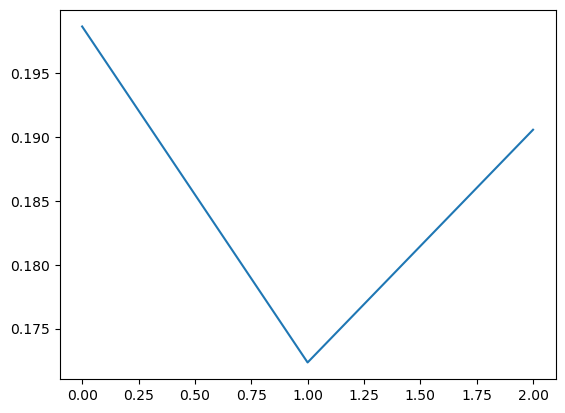

In [37]:
## plot the losses on y axis and epochs on x axis
from matplotlib import pyplot as plt
plt.plot([i.to('cpu').detach().numpy() for i in losses])
plt